## Imports

In [1]:
!pip3 install anytree

In [2]:
from lean_euler import LeanEuler
import networkx as nx
from euler_input_visualization_nxpd import visualize_euler_input
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_query import PWEQuery
from PW_explorer.Custom_Visualization_Functions import euler_visualization_nxpd
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import itertools

In [3]:
import PW_explorer as pwe

## Some Visualization/Clustering Functions

In [116]:
# This actually already exits in PW-E but it has a small bug which should be fixed soon.
from sklearn.cluster import DBSCAN
def dbscan_clustering(dist_matrix, save_to_file=None):

    fig, ax = plt.subplots()

    db = DBSCAN(metric='precomputed', eps=0.5, min_samples=1)
    labels = db.fit_predict(dist_matrix)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) #- (1 if -1 in labels else 0)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    #x_2d = PCA(n_components = 2).fit_transform(dist_matrix)

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)
        xy = dist_matrix[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = dist_matrix[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    ax.set_title('Estimated number of clusters: %d' % n_clusters_)
    if save_to_file is not None:
        fig.savefig(save_to_file)
    return fig, labels

In [115]:
# This actually already exits in PW-E but it has a small bug which should be fixed soon.
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
def linkage_dendrogram(dist_matrix, save_to_folder=None):

    X = squareform(dist_matrix)
    dendrogram_size = (max(25, int(np.sqrt(2 * len(X)) / 10)), 10)
    figs = []
    for dist_type in ['single', 'complete', 'average', 'weighted']:
        fig, ax = plt.subplots(figsize=dendrogram_size)
        linkage_matrix = linkage(X, dist_type)
        dendrogram(linkage_matrix, labels=[str(i) for i in range(len(dist_matrix))], show_leaf_counts=True, ax=ax)
        plt.title("Dendrogram ({})".format(dist_type))
        if save_to_folder is not None:
            fig.savefig(os.path.join(save_to_folder, '{}_dendrogram.png'.format(dist_type)))
        figs.append(fig)
    return figs

# Can we use heuristics to find the ground truth?

### Common Code

In [118]:
def complexity(pw_id, dfs, rels):
    po_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='po_2', relations=rels)
    overlaps_df = dfs[po_df_id] if po_df_id is not None else pd.DataFrame(columns=['pw'])
    eq_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='eq_2', relations=rels)
    equals_df = dfs[eq_df_id] if eq_df_id is not None else pd.DataFrame(columns=['pw'])
    return len(overlaps_df[overlaps_df['pw'] == pw_id]) - len(equals_df[equals_df['pw'] == pw_id])

def find_gt_pw_id(pws, gt_pws, rels, gt_rels):
    for i in range(len(pws)):
        if set([tuple(v) for v in pws[i].rls[pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=rels)]]) == set([tuple(v) for v in gt_pws[0].rls[pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=gt_rels)]]):
            # print("pw {} is the ground truth".format(i+1))
            gt_pw_id = i+1
            return gt_pw_id
    return None

def find_rank(pw_id, complexities):
    curr_rank = 1
    curr_compl = float('inf')
    curr_compl_count = 0
    for p_id, complexity in complexities:
        if curr_compl != complexity:
            curr_compl = complexity
            curr_rank += curr_compl_count
            curr_compl_count = 0
        curr_compl_count += 1
        if p_id == pw_id:
            return curr_rank

def find_rank_by_complexity(target_complexity, complexities):
    curr_rank = 1
    curr_compl = float('inf')
    curr_compl_count = 0
    for p_id, complexity in complexities:
        if curr_compl != complexity:
            curr_compl = complexity
            curr_rank += curr_compl_count
            curr_compl_count = 0
        curr_compl_count += 1
        if complexity == target_complexity:
            return curr_rank

def experiment(gt_dfs, gt_pws, gt_rel_data, tax_data, rels_to_rmv, complexity_func):
    
    gt_complexity = complexity_func(1, gt_dfs, gt_rels)
    
    results = {
        'gt_dfs': gt_dfs,
        'gt_pws': gt_pws,
        'gt_rel_data': gt_rel_data,
        'tax_data': tax_data,
        'gt_complexity': gt_complexity,
        'post_relaxation': {},
    }
    
    for rl_set_to_rmv in rels_to_rmv:
        
        k = list(range(len(gt_rel_data)))
        for rl in rl_set_to_rmv:
            k.remove(rl)
        rel_data = gt_rel_data.iloc[k,:].copy(deep=False)
        rules = LeanEuler.gen_asp_rules(rel_data, tax_data, encoding='mnpw')
        clingo_soln = run_clingo(clingo_rules=rules)
        dfs, rels, pws = load_worlds(clingo_output=clingo_soln, preprocessed=False, reasoner='clingo')
        
        complexities = sorted([(i+1, complexity_func(i+1, dfs, rels)) for i in range(len(pws))], key= lambda x: x[1])
        
        gt_rank = find_rank_by_complexity(gt_complexity, complexities)
        shares_rank_with = sum(1 for pw_id, compl in complexities if compl == gt_complexity) - 1
        
        print("Rank of Ground Truth: {}".format(gt_rank))
        
        results['post_relaxation'][tuple(rl_set_to_rmv)] = {
            'complexities': complexities,
            'dfs': dfs,
            'pws': pws,
            'rels': rels,
            'gt_complexity_rank': gt_rank,
            'shares_rank_with': shares_rank_with,
        }
    
    return results

def plot_performance(results):
    
    print("Constraints:")
    print(results['gt_rel_data'].to_string())
    avg_ranks = []
    num_pws = []
    
    # max_pws_count = max([len(results['post_relaxation'][rel]['pws']) for rel in results['post_relaxation']])
    for rl_set_removed, res in results['post_relaxation'].items():
        plt.figure()
        data = list(zip(*res['complexities']))[1]
        # fixed bin size
        bins = np.arange(-100, 100, 1) # fixed bin size
        plt.xlim([min(data)-5, max(data)+5])
        # plt.ylim(0, max_pws_count+1)
        n, bins, patches = plt.hist(data, bins=bins, alpha=0.5, rwidth=0.8)
        patches[100+results['gt_complexity']].set_color('g')
        plt.title('Constraints Removed: {}'.format(rl_set_removed))
        plt.xlabel('Complexity')
        plt.ylabel('count')
        l_rank = res['gt_complexity_rank']
        r_rank = l_rank + res['shares_rank_with']
        n_pws = len(res['pws'])
        if n_pws != 1:
            avg_ranks.append((l_rank+r_rank)/2)
            num_pws.append(n_pws)
        text = "Ground Truth Rank: {}\nNumber of PWs: {}".format(
            str(l_rank) if l_rank == r_rank else 
            '{}-{}'.format(l_rank, r_rank), n_pws)
        plt.annotate(text, xy=(1, 1), xytext=(-15, -15), fontsize=10,
                     xycoords='axes fraction', textcoords='offset points',
                     bbox=dict(facecolor='white', alpha=0.8),
                     horizontalalignment='right', verticalalignment='top')
    
    plt.show()
    
    avg_ranks = np.array(avg_ranks)
    num_pws = np.array(num_pws)
    print("Performance Score: {}".format(1 - np.average(avg_ranks/num_pws, weights=(num_pws))))

## CEN-NDC

In [117]:
cleantax_file = [
    '# Taxonomy-1: NSF BD Hubs http://www.nsf.gov/pubs/2015/nsf15562/nsf15562.htm',
    '# Taxonomy 2: http://www.nationaldiversitycouncil.org/wp-content/uploads/2011/12/us_regions.jpg',
    'taxonomy CEN Census_Regions',
    '(USA Northeast Midwest South West)',
    'taxonomy NDC National_Diversity_Council',
    '(USA Midwest Northeast Southeast Southwest West)',
    'articulations CEN NDC',
    '[CEN.USA equals NDC.USA]',
    '[CEN.West includes NDC.West]',
    '[CEN.West disjoint NDC.Northeast]',
    '[CEN.South overlaps NDC.Southwest]',
    '[CEN.South includes NDC.Southeast]',
    '[CEN.Midwest equals NDC.Midwest]',
    '[CEN.Northeast is_included_in NDC.Northeast]',
    ''
]

In [119]:
gt_rel_data, tax_data = LeanEuler.parse_cleantax(cleantax_file)

In [120]:
gt_rel_data

,Node1,Relation,Node2
0,"""CEN_USA""",parent,"""CEN_Northeast"""
1,"""CEN_USA""",parent,"""CEN_Midwest"""
2,"""CEN_USA""",parent,"""CEN_South"""
3,"""CEN_USA""",parent,"""CEN_West"""
4,"""NDC_USA""",parent,"""NDC_Midwest"""
5,"""NDC_USA""",parent,"""NDC_Northeast"""
6,"""NDC_USA""",parent,"""NDC_Southeast"""
7,"""NDC_USA""",parent,"""NDC_Southwest"""
8,"""NDC_USA""",parent,"""NDC_West"""
9,"""CEN_USA""",=,"""NDC_USA"""


In [121]:
tax_data

{'CEN': {'CEN': Node('/CEN'),
  'USA': Node('/CEN/"CEN_USA"'),
  'Northeast': Node('/CEN/"CEN_USA"/"CEN_Northeast"'),
  'Midwest': Node('/CEN/"CEN_USA"/"CEN_Midwest"'),
  'South': Node('/CEN/"CEN_USA"/"CEN_South"'),
  'West': Node('/CEN/"CEN_USA"/"CEN_West"')},
 'NDC': {'NDC': Node('/NDC'),
  'USA': Node('/NDC/"NDC_USA"'),
  'Midwest': Node('/NDC/"NDC_USA"/"NDC_Midwest"'),
  'Northeast': Node('/NDC/"NDC_USA"/"NDC_Northeast"'),
  'Southeast': Node('/NDC/"NDC_USA"/"NDC_Southeast"'),
  'Southwest': Node('/NDC/"NDC_USA"/"NDC_Southwest"'),
  'West': Node('/NDC/"NDC_USA"/"NDC_West"')}}

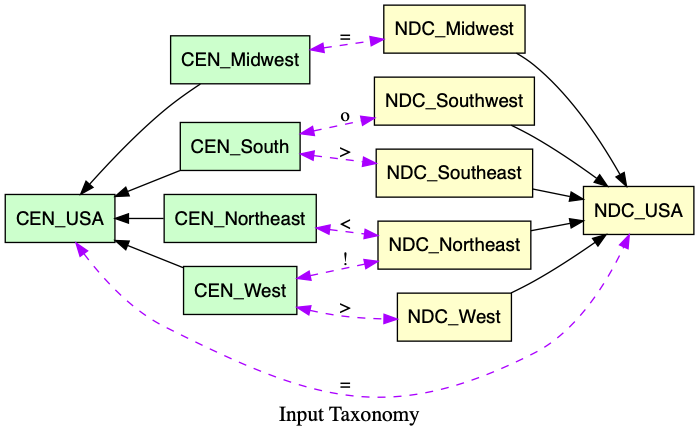

In [123]:
gt_G = visualize_euler_input(gt_rel_data, tax_data)
draw(gt_G)

In [122]:
gt_rules = LeanEuler.gen_asp_rules(gt_rel_data, tax_data, encoding='mnpw')
print('\n'.join(gt_rules))

r(1..29).

% Region Meanings
in(X, M) :- r(M), concept(X, T, N), N1=N+1, bit(M, T, N1).
out(X, M) :- r(M), concept(X, T, N), N1=N+1, not bit(M, T, N1).
in(X, M) :- r(M), concept2(X, _), not out(X, M).
irs(M) :- in(X, M), out(X, M), r(M), concept2(X, _).

% Region Constraints
irs(X) :- ir(X, _).
vrs(X) :- vr(X, _).
vr(X, X) :- not irs(X), r(X).
ir(X, X) :- not vrs(X), r(X).
:- vrs(X), irs(X).

concept2(A, B) :- concept(A,B,_).

% Taxonomy Description

%  Euler Bit
bit(M, 0, V) :- r(M), M1=M/1, V = M1 \ 5.

%  Euler Bit
bit(M, 1, V) :- r(M), M1=M/5, V = M1 \ 6.

concept2("CEN_USA", 0).
concept("CEN_Northeast", 0, 0).
concept("CEN_Midwest", 0, 1).
concept("CEN_South", 0, 2).
concept("CEN_West", 0, 3).
concept2("NDC_USA", 1).
concept("NDC_Midwest", 1, 0).
concept("NDC_Northeast", 1, 1).
concept("NDC_Southeast", 1, 2).
concept("NDC_Southwest", 1, 3).
concept("NDC_West", 1, 4).

% "CEN_Northeast" isa "CEN_USA"
ir(X, r63) :- in("CEN_Northeast", X), out("CEN_USA", X).
:- #count {X : vrs(X), in

In [124]:
gt_clingo_soln = run_clingo(clingo_rules=gt_rules)
print('\n'.join(gt_clingo_soln))

Answer: 1
u("CEN_Northeast") u("CEN_Midwest") u("CEN_South") u("CEN_West") u("NDC_Midwest") u("NDC_Northeast") u("NDC_Southeast") u("NDC_Southwest") u("NDC_West") u("CEN_USA") u("NDC_USA") bl("CEN_USA","CEN_Northeast") bl("CEN_USA","CEN_Midwest") bl("CEN_USA","CEN_South") bl("CEN_USA","CEN_West") bl("NDC_USA","NDC_Midwest") bl("NDC_USA","NDC_Northeast") bl("NDC_USA","NDC_Southeast") bl("NDC_USA","NDC_Southwest") bl("NDC_USA","NDC_West") pp("CEN_Northeast","CEN_USA") pp("CEN_Midwest","CEN_USA") pp("CEN_South","CEN_USA") pp("CEN_West","CEN_USA") pp("NDC_Midwest","NDC_USA") pp("NDC_Northeast","NDC_USA") pp("NDC_Southeast","NDC_USA") pp("NDC_Southwest","NDC_USA") pp("NDC_West","NDC_USA") rel("CEN_USA","NDC_USA","=") rel("CEN_Midwest","NDC_Midwest","=") rel("CEN_Northeast","NDC_Midwest","!") rel("CEN_Northeast","NDC_Southeast","!") rel("CEN_Northeast","NDC_Southwest","!") rel("CEN_Northeast","NDC_West","!") rel("CEN_Midwest","NDC_Northeast","!") rel("CEN_Midwest","NDC_Southeast","!") rel("C

In [125]:
gt_dfs, gt_rels, gt_pws = load_worlds(clingo_output=gt_clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 1


In [126]:
list(map(lambda x: x.__dict__, gt_rels))

[{'relation_name': 'u_1', 'arity': 1, 'r_id': 0},
 {'relation_name': 'bl_2', 'arity': 2, 'r_id': 1},
 {'relation_name': 'pp_2', 'arity': 2, 'r_id': 2},
 {'relation_name': 'rel_3', 'arity': 3, 'r_id': 3},
 {'relation_name': 'eq_2', 'arity': 2, 'r_id': 4},
 {'relation_name': 'po_2', 'arity': 2, 'r_id': 5},
 {'relation_name': 'dr_2', 'arity': 2, 'r_id': 6}]

In [127]:
gt_pws_vizs = euler_visualization_nxpd.visualize(dfs=gt_dfs, pws=gt_pws, relations=gt_rels, conn=None, project_name='cen_ndc', save_to_file=False)

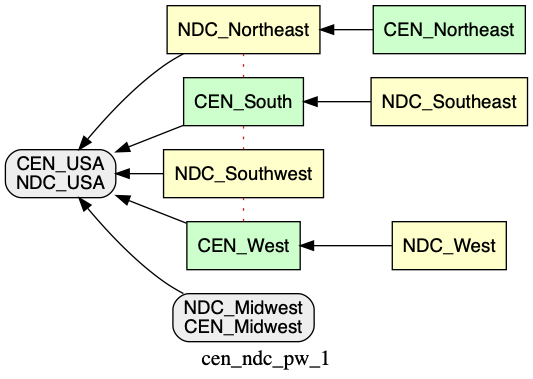

In [128]:
draw(gt_pws_vizs[0])

In [130]:
articulation_sets_to_rmv = itertools.combinations(range(9, len(gt_rel_data)), r=1)

In [131]:
results = experiment(gt_dfs, gt_pws, gt_rel_data, tax_data, articulation_sets_to_rmv, complexity)

Number of Models: 30
Rank of Ground Truth: 1
Number of Models: 3
Rank of Ground Truth: 2
Number of Models: 3
Rank of Ground Truth: 1
Number of Models: 2
Rank of Ground Truth: 2
Number of Models: 3
Rank of Ground Truth: 1
Number of Models: 51
Rank of Ground Truth: 1
Number of Models: 5
Rank of Ground Truth: 3


Constraints:
              Node1 Relation            Node2
0         "CEN_USA"   parent  "CEN_Northeast"
1         "CEN_USA"   parent    "CEN_Midwest"
2         "CEN_USA"   parent      "CEN_South"
3         "CEN_USA"   parent       "CEN_West"
4         "NDC_USA"   parent    "NDC_Midwest"
5         "NDC_USA"   parent  "NDC_Northeast"
6         "NDC_USA"   parent  "NDC_Southeast"
7         "NDC_USA"   parent  "NDC_Southwest"
8         "NDC_USA"   parent       "NDC_West"
9         "CEN_USA"        =        "NDC_USA"
10       "CEN_West"        >       "NDC_West"
11       "CEN_West"        !  "NDC_Northeast"
12      "CEN_South"        o  "NDC_Southwest"
13      "CEN_South"        >  "NDC_Southeast"
14    "CEN_Midwest"        =    "NDC_Midwest"
15  "CEN_Northeast"        <  "NDC_Northeast"


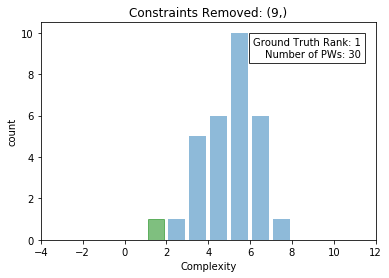

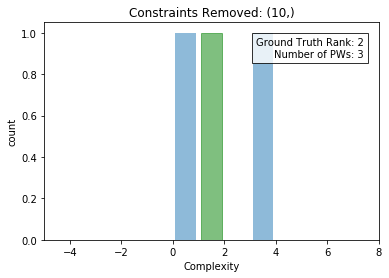

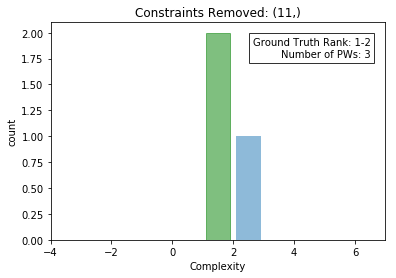

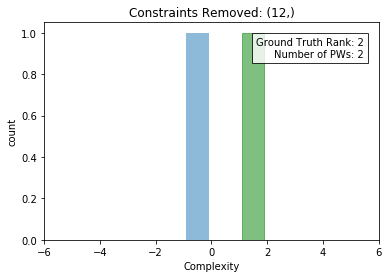

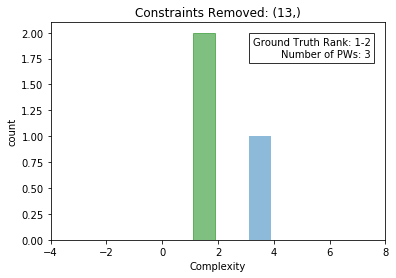

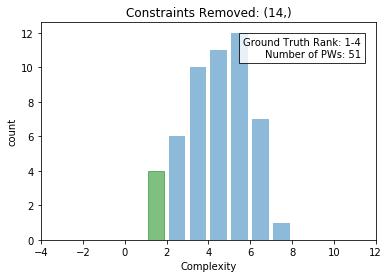

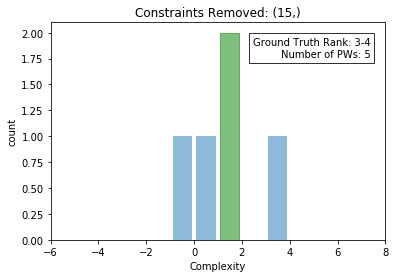

Performance Score: 0.8556701030927836


In [132]:
plot_performance(results)

In [133]:
import pickle as pkl
# with open('cen_ndc_results.pkl', 'wb') as f:
#     pkl.dump(results, f)

In [134]:
# with open('cen_ndc_results.pkl', 'rb') as f:
#     results = pkl.load(f)

## NDC-TZ

## CEN-TZ

## Magnolia Examples

## Cronquist Examples

## Beer-Tax Examples (TBD)

## Autos Example (TBD)

# Clustering Similar Solutions

## Abstract-4 (Magnificent-7)

In [33]:
cleantax_file = [
    'taxonomy T1 Source',
    '(a b c)',
    'taxonomy T2 Target',
    '(A B C)',
    'articulations T1 T2',
    '[T1.a equals T2.A]',
]

In [34]:
rel_data, tax_data = LeanEuler.parse_cleantax(cleantax_file)

In [35]:
rel_data

,Node1,Relation,Node2
0,"""T1_a""",parent,"""T1_b"""
1,"""T1_a""",parent,"""T1_c"""
2,"""T2_A""",parent,"""T2_B"""
3,"""T2_A""",parent,"""T2_C"""
4,"""T1_a""",=,"""T2_A"""


In [36]:
tax_data

{'T1': {'T1': Node('/T1'),
  'a': Node('/T1/"T1_a"'),
  'b': Node('/T1/"T1_a"/"T1_b"'),
  'c': Node('/T1/"T1_a"/"T1_c"')},
 'T2': {'T2': Node('/T2'),
  'A': Node('/T2/"T2_A"'),
  'B': Node('/T2/"T2_A"/"T2_B"'),
  'C': Node('/T2/"T2_A"/"T2_C"')}}

In [37]:
mag7_rules = LeanEuler.gen_asp_rules(rel_data, tax_data, encoding='mnpw')
print('\n'.join(mag7_rules))

r(1..8).

% Region Meanings
in(X, M) :- r(M), concept(X, T, N), N1=N+1, bit(M, T, N1).
out(X, M) :- r(M), concept(X, T, N), N1=N+1, not bit(M, T, N1).
in(X, M) :- r(M), concept2(X, _), not out(X, M).
irs(M) :- in(X, M), out(X, M), r(M), concept2(X, _).

% Region Constraints
irs(X) :- ir(X, _).
vrs(X) :- vr(X, _).
vr(X, X) :- not irs(X), r(X).
ir(X, X) :- not vrs(X), r(X).
:- vrs(X), irs(X).

concept2(A, B) :- concept(A,B,_).

% Taxonomy Description

%  Euler Bit
bit(M, 0, V) :- r(M), M1=M/1, V = M1 \ 3.

%  Euler Bit
bit(M, 1, V) :- r(M), M1=M/3, V = M1 \ 3.

concept2("T1_a", 0).
concept("T1_b", 0, 0).
concept("T1_c", 0, 1).
concept2("T2_A", 1).
concept("T2_B", 1, 0).
concept("T2_C", 1, 1).

% "T1_b" isa "T1_a"
ir(X, r51) :- in("T1_b", X), out("T1_a", X).
:- #count {X : vrs(X), in("T1_b", X), in("T1_a", X)} = 0.

% "T1_c" isa "T1_a"
ir(X, r52) :- in("T1_c", X), out("T1_a", X).
:- #count {X : vrs(X), in("T1_c", X), in("T1_a", X)} = 0.

% "T2_B" isa "T2_A"
ir(X, r54) :- in("T2_B", X), ou

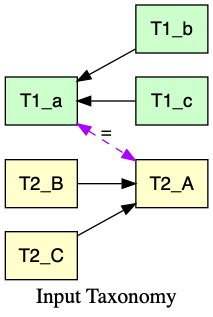

In [38]:
mag7_G = visualize_euler_input(rel_data, tax_data)
draw(mag7_G)

In [39]:
mag7_clingo_soln = run_clingo(clingo_rules=mag7_rules)
print('\n'.join(mag7_clingo_soln))

Answer: 1
u("T1_b") u("T1_c") u("T2_B") u("T2_C") u("T1_a") u("T2_A") bl("T1_a","T1_b") bl("T1_a","T1_c") bl("T2_A","T2_B") bl("T2_A","T2_C") pp("T1_b","T1_a") pp("T1_c","T1_a") pp("T2_B","T2_A") pp("T2_C","T2_A") rel("T1_a","T2_A","=") rel("T1_b","T2_C","=") rel("T1_c","T2_B","=") rel("T1_b","T2_B","!") rel("T1_c","T2_C","!") rel("T1_a","T2_B",">") rel("T1_a","T2_C",">") rel("T1_b","T2_A","<") rel("T1_c","T2_A","<") eq("T1_a","T2_A") eq("T1_b","T2_C") eq("T1_c","T2_B") dr("T1_b","T2_B") dr("T1_c","T2_C") pp("T1_b","T2_A") pp("T1_c","T2_A") pp("T2_B","T1_a") pp("T2_C","T1_a")
Answer: 2
u("T1_b") u("T1_c") u("T2_B") u("T2_C") u("T1_a") u("T2_A") bl("T1_a","T1_b") bl("T1_a","T1_c") bl("T2_A","T2_B") bl("T2_A","T2_C") pp("T1_b","T1_a") pp("T1_c","T1_a") pp("T2_B","T2_A") pp("T2_C","T2_A") rel("T1_a","T2_A","=") rel("T1_b","T2_B","!") rel("T1_a","T2_B",">") rel("T1_a","T2_C",">") rel("T1_c","T2_B",">") rel("T1_c","T2_C","o") rel("T1_b","T2_A","<") rel("T1_b","T2_C","<") rel("T1_c","T2_A","

That's where the 7 comes from

In [59]:
dfs, rels, pws = load_worlds(clingo_output=mag7_clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 7


In [60]:
list(map(lambda x: x.__dict__, rels))

[{'relation_name': 'u_1', 'arity': 1, 'r_id': 0},
 {'relation_name': 'bl_2', 'arity': 2, 'r_id': 1},
 {'relation_name': 'pp_2', 'arity': 2, 'r_id': 2},
 {'relation_name': 'rel_3', 'arity': 3, 'r_id': 3},
 {'relation_name': 'eq_2', 'arity': 2, 'r_id': 4},
 {'relation_name': 'dr_2', 'arity': 2, 'r_id': 5},
 {'relation_name': 'po_2', 'arity': 2, 'r_id': 6}]

In [61]:
pws_vizs = euler_visualization_nxpd.visualize(dfs=dfs, pws=pws, relations=rels, conn=None, project_name='mag7', save_to_file=False)

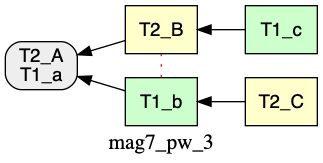

In [114]:
draw(pws_vizs[2])

In [100]:
def mag7_distance(dfs, rels, pw_id1, pw_id2):
    eq_rel_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='eq_2', relations=rels)
    eq_df = dfs[eq_rel_id]
    eq_diff = abs(len(eq_df[eq_df['pw'] == pw_id1]) - len(eq_df[eq_df['pw'] == pw_id2]))
    
    po_rel_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='po_2', relations=rels)
    po_df = dfs[po_rel_id]
    po_diff = abs(len(po_df[po_df['pw'] == pw_id1]) - len(po_df[po_df['pw'] == pw_id2]))
    
    return abs(po_diff - eq_diff)

In [107]:
dist_matrix = np.zeros((len(pws), len(pws)))
for i in range(1, len(pws)+1):
    for j in range(i+1, len(pws)+1):
        dist_matrix[i-1][j-1] = dist_matrix[j-1][i-1] = mag7_distance(dfs, rels, i, j)

array([0, 1, 1, 0, 1, 1, 2])

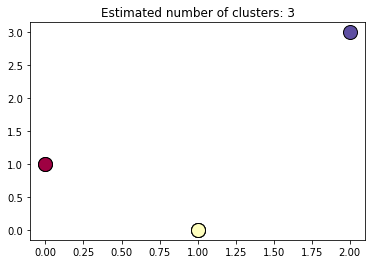

In [103]:
dbscan_fig, dbscan_labels = dbscan_clustering(dist_matrix, None)
dbscan_labels

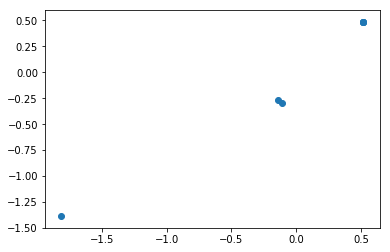

In [104]:
sklearn_mds_g = pwe.visualize.mds_sklearn(A=dist_matrix)

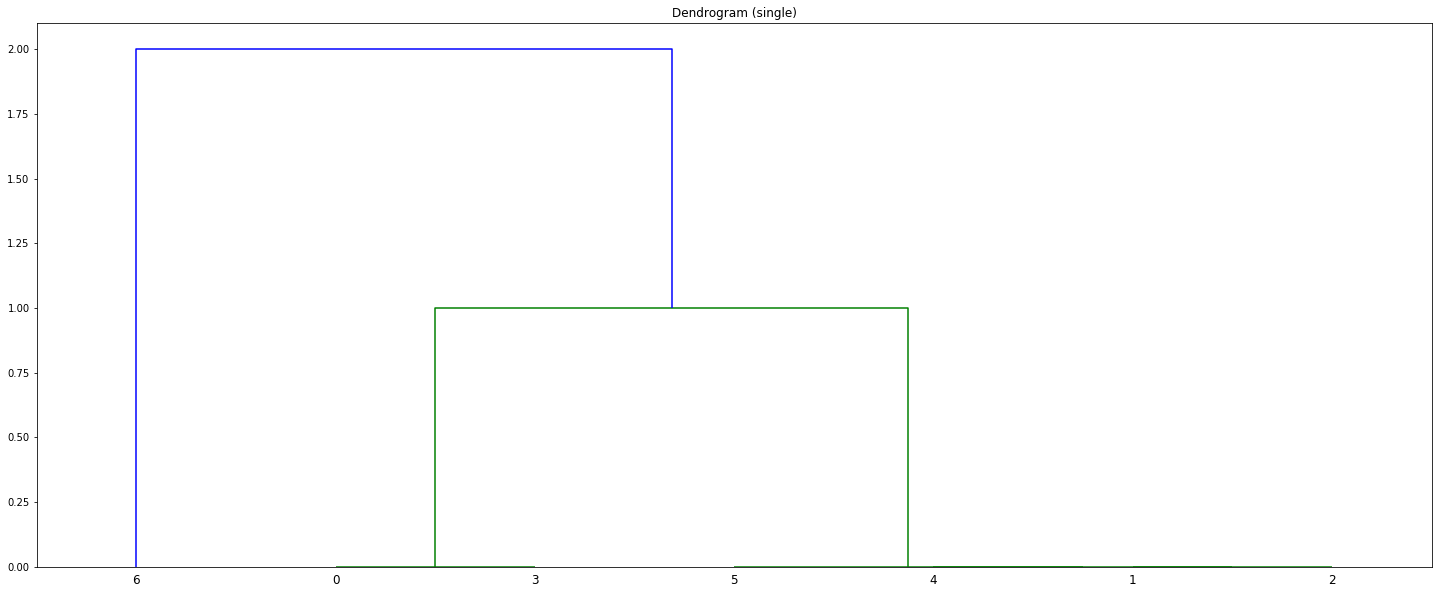

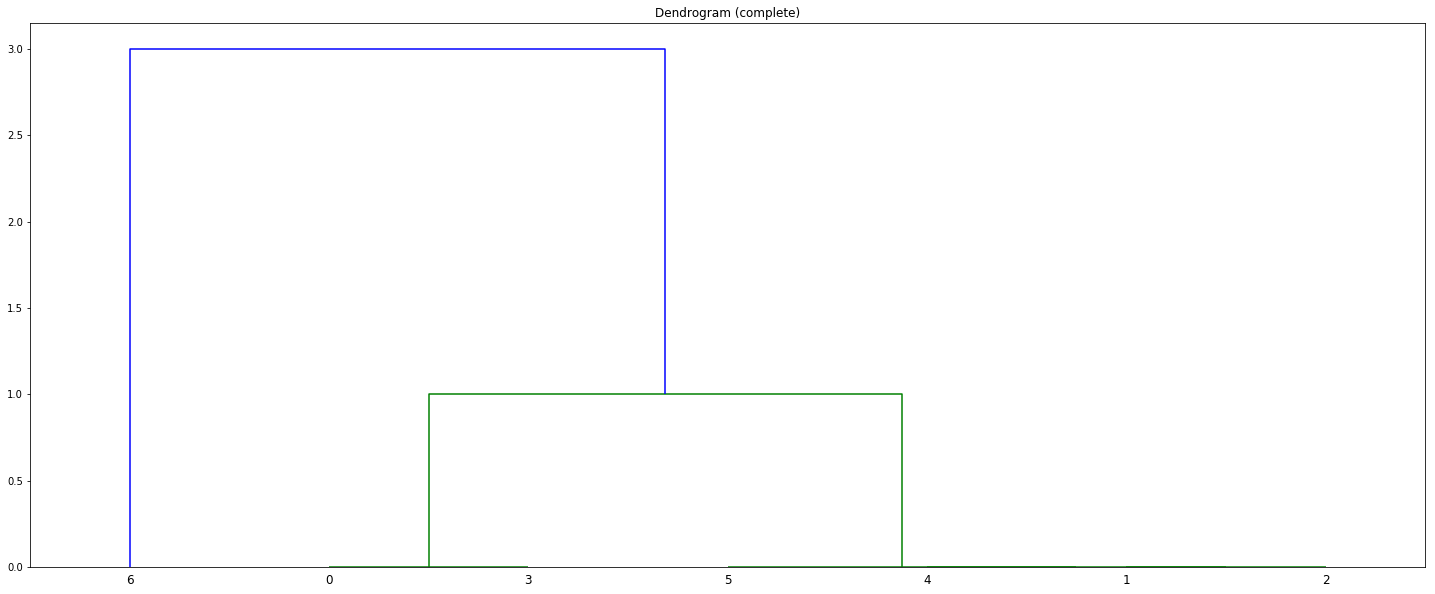

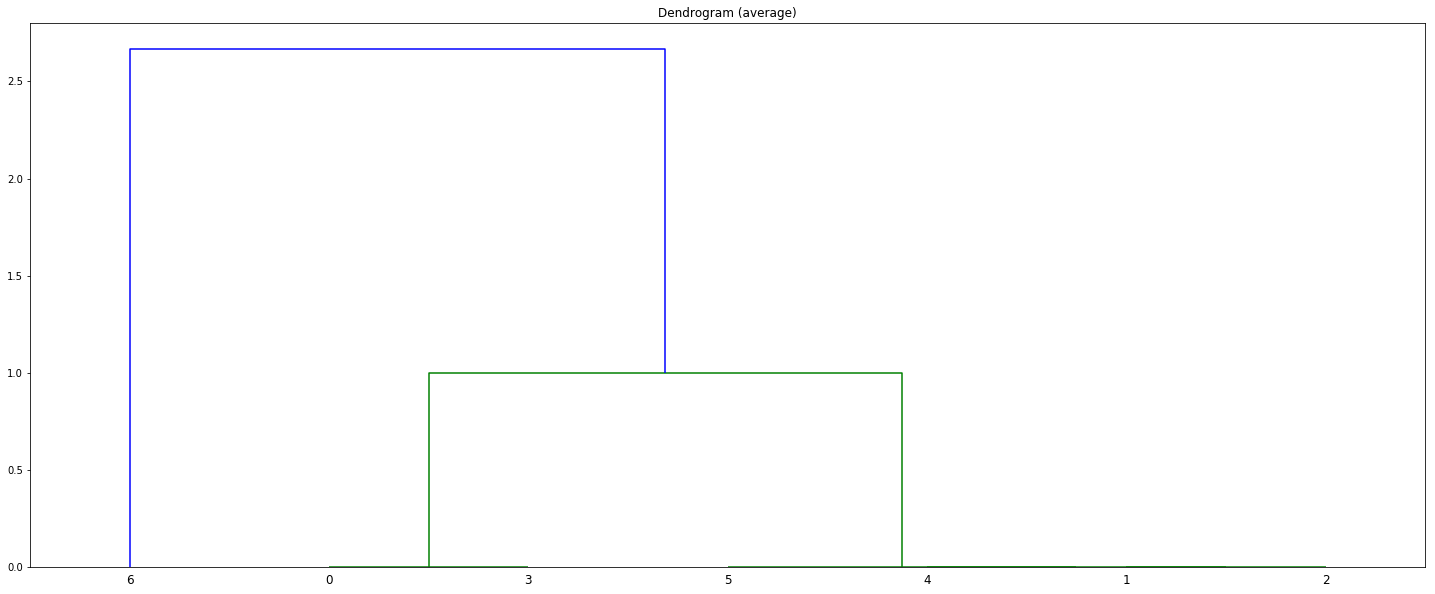

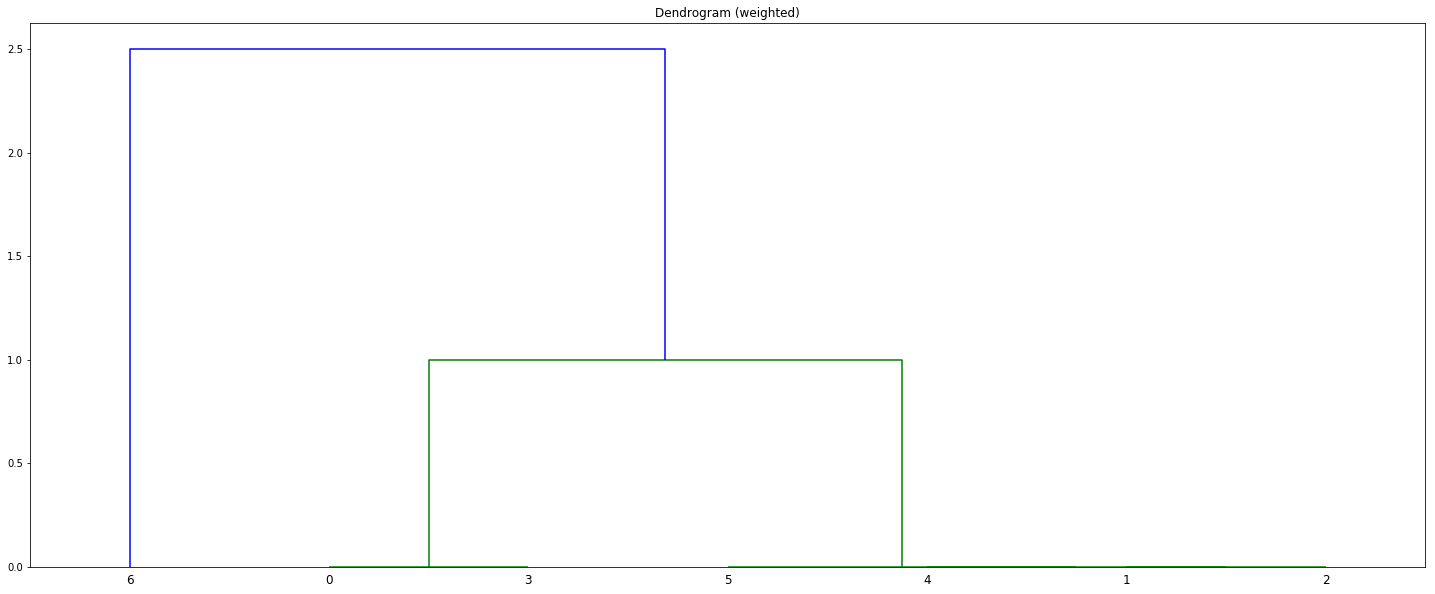

In [106]:
dendrograms = linkage_dendrogram(dist_matrix=dist_matrix, save_to_folder=None)

In [4]:
fname = 'Preprocessed_CleanTax_Input/abstract4_mnpw.txt'
# fname = 'Preprocessed_CleanTax_Input/auto_example.txt'
# fname = 'Preprocessed_CleanTax_Input/cen_ndc_1pw.txt'
# fname = 'Preprocessed_CleanTax_Input/beer_tax.txt'
# fname = 'Tests/cronquist.txt'
# fname = 'Tests/cronquist_555.txt'
# fname = 'Tests/magnolia_2012.txt'
# fname = 'Tests/magnolia_91_14.txt'
# fname = 'Tests/magnolia_83_14.txt'
# fname = 'Tests/magnolia_33_14.txt'
# fname = 'Tests/magnolia_68_14.txt'
# fname = 'Tests/autos.txt'

In [5]:
with open(fname, 'r') as f:
    cleantax_file = f.read().split('\n')
cleantax_file

['taxonomy 1 Taxonomy1',
 '(A B C D E)',
 'taxonomy 2 Taxonomy2',
 '(A B D F G)',
 'articulation abs abstract',
 '[1.A {is_included_in equals} 2.A]',
 '[1.B equals 2.B]',
 '[1.C {is_included_in overlaps} 2.F]',
 '[1.D equals 2.D]',
 '[1.E {equals overlaps} 2.G]']

In [273]:
# cleantax_file = ['taxonomy T1 Source',
#  '(Automobile Sedan Wagon SUV)',
#  '(Sedan Sedan_Audi Sedan_BMW)',
#  '(Wagon Wagon_Audi Wagon_BMW)',
#  'taxonomy T2 Target',
#  '(Automobile Audi BMW)',
#  '(Audi Sedan_Audi Wagon_Audi SUV_Audi)',
#  '(BMW Sedan_BMW SUV_BMW)',
#  'articulations T1 T2',
#  '[T1.Automobile equals T2.Automobile]',
#  '[T1.Sedan_Audi equals T2.Sedan_Audi]',
#  '[T1.Sedan_BMW equals T2.Sedan_BMW]',
#  '[T1.Wagon_Audi equals T2.Wagon_Audi]',
#  '[T1.Wagon_BMW is_included_in T2.BMW]',
#  '[T2.SUV_Audi is_included_in T1.SUV]',
#  '[T1.SUV includes T2.SUV_BMW]',
#  '']

In [274]:
# cleantax_file = ['taxonomy T1 Source',
#  '(K C)',
#  '(C A B)',
#  'taxonomy T2 Target',
#  '(K D B)',
#  'articulations T1 T2',
#  '[T1.K equals T2.K]',
#  '[T1.A overlaps T2.D]',
#  '[T1.B is_included_in T2.D]',
#  '[T1.C includes T2.D]',
#  ]

In [15]:
# CEN-NDC
cleantax_file = [
    '# Taxonomy-1: NSF BD Hubs http://www.nsf.gov/pubs/2015/nsf15562/nsf15562.htm',
    '# Taxonomy 2: http://www.nationaldiversitycouncil.org/wp-content/uploads/2011/12/us_regions.jpg',
    '#',
    'taxonomy CEN Census_Regions',
    '(USA Northeast Midwest South West)',
    'taxonomy NDC National_Diversity_Council',
    '(USA Midwest Northeast Southeast Southwest West)',
    'articulations CEN NDC',
    '[CEN.USA equals NDC.USA]',
    '[CEN.West includes NDC.West]',
    '[CEN.West disjoint NDC.Northeast]',
    '[CEN.South overlaps NDC.Southwest]',
    '[CEN.South includes NDC.Southeast]',
    '[CEN.Midwest equals NDC.Midwest]',
    '[CEN.Northeast is_included_in NDC.Northeast]',
    '']

In [276]:
# CEN-TZ
# cleantax_file = [
#     'taxonomy CEN Census_Regions',
#     '(USA Midwest South West Northeast)',
#     'taxonomy TZ Time_Zone',
#     '(USA Pacific Mountain Central Eastern)',
#     'articulations CEN TZ',
#     '[CEN.Midwest disjoint TZ.Pacific]',
#     '[CEN.Midwest overlaps TZ.Eastern]',
#     '[CEN.Midwest overlaps TZ.Mountain]',
#     '[CEN.Northeast is_included_in TZ.Eastern]',
#     '[CEN.South disjoint TZ.Pacific]',
#     '[CEN.South overlaps TZ.Central]',
#     '[CEN.South overlaps TZ.Eastern]',
#     '[CEN.South overlaps TZ.Mountain]',
#     '[CEN.USA equals TZ.USA]',
#     '[CEN.West disjoint TZ.Central]',
#     '[CEN.West disjoint TZ.Eastern]',
#     '[CEN.West overlaps TZ.Mountain]',
#     '']

In [7]:
# NDC TZ
# cleantax_file = [
#     'taxonomy NDC National_Diversity_Council',
#     '(USA Midwest Northeast Southeast Southwest West)',
#     'taxonomy TZ Time_Zone',
#     '(USA Pacific Mountain Central Eastern)',
#     'articulations NDC TZ',
#     '[NDC.Midwest overlaps TZ.Eastern]',
#     '[NDC.Midwest overlaps TZ.Mountain]',
#     '[NDC.USA equals TZ.USA]',
#     '[NDC.Southwest overlaps TZ.Mountain]',
#     '[NDC.Southeast disjoint TZ.Mountain]',
#     '[NDC.West disjoint TZ.Central]',
#     '[NDC.Southeast overlaps TZ.Central]',
#     '[NDC.Midwest overlaps TZ.Central]',
#     '[NDC.Northeast is_included_in TZ.Eastern]',
#     '[NDC.Southwest disjoint TZ.Eastern]',
#     '[NDC.West includes TZ.Pacific]',
#     '[NDC.West disjoint TZ.Eastern]',
#     '']

In [16]:
gt_rel_data, tax_data = LeanEuler.parse_cleantax(cleantax_file)

In [17]:
gt_rel_data

,Node1,Relation,Node2
0,"""CEN_USA""",parent,"""CEN_Northeast"""
1,"""CEN_USA""",parent,"""CEN_Midwest"""
2,"""CEN_USA""",parent,"""CEN_South"""
3,"""CEN_USA""",parent,"""CEN_West"""
4,"""NDC_USA""",parent,"""NDC_Midwest"""
5,"""NDC_USA""",parent,"""NDC_Northeast"""
6,"""NDC_USA""",parent,"""NDC_Southeast"""
7,"""NDC_USA""",parent,"""NDC_Southwest"""
8,"""NDC_USA""",parent,"""NDC_West"""
9,"""CEN_USA""",=,"""NDC_USA"""


In [18]:
tax_data

{'CEN': {'CEN': Node('/CEN'),
  'USA': Node('/CEN/"CEN_USA"'),
  'Northeast': Node('/CEN/"CEN_USA"/"CEN_Northeast"'),
  'Midwest': Node('/CEN/"CEN_USA"/"CEN_Midwest"'),
  'South': Node('/CEN/"CEN_USA"/"CEN_South"'),
  'West': Node('/CEN/"CEN_USA"/"CEN_West"')},
 'NDC': {'NDC': Node('/NDC'),
  'USA': Node('/NDC/"NDC_USA"'),
  'Midwest': Node('/NDC/"NDC_USA"/"NDC_Midwest"'),
  'Northeast': Node('/NDC/"NDC_USA"/"NDC_Northeast"'),
  'Southeast': Node('/NDC/"NDC_USA"/"NDC_Southeast"'),
  'Southwest': Node('/NDC/"NDC_USA"/"NDC_Southwest"'),
  'West': Node('/NDC/"NDC_USA"/"NDC_West"')}}

In [19]:
gt_rules = LeanEuler.gen_asp_rules(gt_rel_data, tax_data, encoding='mnpw')

In [20]:
print('\n'.join(gt_rules))

r(1..29).

% Region Meanings
in(X, M) :- r(M), concept(X, T, N), N1=N+1, bit(M, T, N1).
out(X, M) :- r(M), concept(X, T, N), N1=N+1, not bit(M, T, N1).
in(X, M) :- r(M), concept2(X, _), not out(X, M).
irs(M) :- in(X, M), out(X, M), r(M), concept2(X, _).

% Region Constraints
irs(X) :- ir(X, _).
vrs(X) :- vr(X, _).
vr(X, X) :- not irs(X), r(X).
ir(X, X) :- not vrs(X), r(X).
:- vrs(X), irs(X).

concept2(A, B) :- concept(A,B,_).

% Taxonomy Description

%  Euler Bit
bit(M, 0, V) :- r(M), M1=M/1, V = M1 \ 5.

%  Euler Bit
bit(M, 1, V) :- r(M), M1=M/5, V = M1 \ 6.

concept2("CEN_USA", 0).
concept("CEN_Northeast", 0, 0).
concept("CEN_Midwest", 0, 1).
concept("CEN_South", 0, 2).
concept("CEN_West", 0, 3).
concept2("NDC_USA", 1).
concept("NDC_Midwest", 1, 0).
concept("NDC_Northeast", 1, 1).
concept("NDC_Southeast", 1, 2).
concept("NDC_Southwest", 1, 3).
concept("NDC_West", 1, 4).

% "CEN_Northeast" isa "CEN_USA"
ir(X, r31) :- in("CEN_Northeast", X), out("CEN_USA", X).
:- #count {X : vrs(X), in

In [21]:
# Alternatively, short-cut
# rules = LeanEuler.gen_asp_rules_from_cleantax(cleantax_file, encoding='mnpw')
# print('\n'.join(rules))

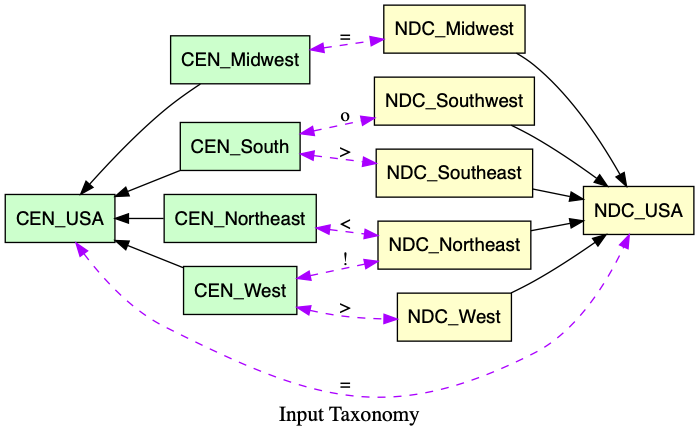

In [22]:
gt_G = visualize_euler_input(gt_rel_data, tax_data)
draw(gt_G)

In [23]:
gt_clingo_soln = run_clingo(clingo_rules=gt_rules)
print('\n'.join(gt_clingo_soln))

Answer: 1
u("CEN_Northeast") u("CEN_Midwest") u("CEN_South") u("CEN_West") u("NDC_Midwest") u("NDC_Northeast") u("NDC_Southeast") u("NDC_Southwest") u("NDC_West") u("CEN_USA") u("NDC_USA") bl("CEN_USA","CEN_Northeast") bl("CEN_USA","CEN_Midwest") bl("CEN_USA","CEN_South") bl("CEN_USA","CEN_West") bl("NDC_USA","NDC_Midwest") bl("NDC_USA","NDC_Northeast") bl("NDC_USA","NDC_Southeast") bl("NDC_USA","NDC_Southwest") bl("NDC_USA","NDC_West") pp("CEN_Northeast","CEN_USA") pp("CEN_Midwest","CEN_USA") pp("CEN_South","CEN_USA") pp("CEN_West","CEN_USA") pp("NDC_Midwest","NDC_USA") pp("NDC_Northeast","NDC_USA") pp("NDC_Southeast","NDC_USA") pp("NDC_Southwest","NDC_USA") pp("NDC_West","NDC_USA") rel("CEN_Northeast","NDC_Midwest","!") rel("CEN_Northeast","NDC_Southeast","!") rel("CEN_Northeast","NDC_Southwest","!") rel("CEN_Northeast","NDC_West","!") rel("CEN_Midwest","NDC_Northeast","!") rel("CEN_Midwest","NDC_Southeast","!") rel("CEN_Midwest","NDC_Southwest","!") rel("CEN_Midwest","NDC_West","!")

In [24]:
gt_dfs, gt_rels, gt_pws = load_worlds(clingo_output=gt_clingo_soln, preprocessed=False, reasoner='clingo')

Number of Models: 1


In [25]:
#gt_dfs.append(pd.DataFrame(columns=['pw', 'x1', 'x2']))

In [26]:
#gt_rels.append(pwe.pwe_helper.Relation(relation_name='po_2'))

In [27]:
# gt_rels[6].r_id = 6
# gt_rels[6].arity = 2

In [28]:
list(map(lambda x: x.__dict__, gt_rels))

[{'relation_name': 'u_1', 'arity': 1, 'r_id': 0},
 {'relation_name': 'bl_2', 'arity': 2, 'r_id': 1},
 {'relation_name': 'pp_2', 'arity': 2, 'r_id': 2},
 {'relation_name': 'rel_3', 'arity': 3, 'r_id': 3},
 {'relation_name': 'eq_2', 'arity': 2, 'r_id': 4},
 {'relation_name': 'po_2', 'arity': 2, 'r_id': 5},
 {'relation_name': 'dr_2', 'arity': 2, 'r_id': 6}]

In [29]:
gt_pws_vizs = euler_visualization_nxpd.visualize(dfs=gt_dfs, pws=gt_pws, relations=gt_rels, conn=None, project_name='ndc_tz', save_to_file=False)

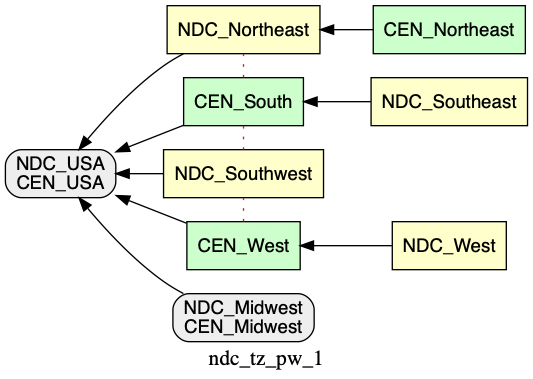

In [30]:
draw(gt_pws_vizs[0])

In [31]:
# PWEQuery.unique_tuples(relations=gt_rels, col_names=['x1','x2','x3'], dfs=gt_dfs, expected_pws=len(gt_pws), 
#                        rl_id=pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=gt_rels),
#                       pws_to_consider=[1,2])

In [32]:
#G = gt_pws_vizs[0]

In [33]:
#draw(nx.bfs_tree(G=G, source='APG_Angiosperms\nC_Magnoliophyta', reverse=True))

In [34]:
def complexity(pw_id, dfs, rels):
    po_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='po_2', relations=rels)
    overlaps_df = dfs[po_df_id] if po_df_id is not None else pd.DataFrame(columns=['pw'])
    eq_df_id = pwe.pwe_helper.rel_id_from_rel_name(rel_name='eq_2', relations=rels)
    equals_df = dfs[eq_df_id] if eq_df_id is not None else pd.DataFrame(columns=['pw'])
    return len(overlaps_df[overlaps_df['pw'] == pw_id]) - len(equals_df[equals_df['pw'] == pw_id])

In [39]:
def dist_func(rels, dfs, pws, pw_id_1, pw_id_2):
    return len(PWEQuery.unique_tuples(relations=rels, 
                                      col_names=['x1','x2','x3'], 
                                      dfs=dfs, do_print=False, 
                                      expected_pws=len(pws), 
                                      rl_id=pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=rels), 
                                      pws_to_consider=[pw_id_1, pw_id_2]))

In [40]:
def find_gt_pw_id(pws, gt_pws, rels, gt_rels):
    for i in range(len(pws)):
        if set([tuple(v) for v in pws[i].rls[pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=rels)]]) == set([tuple(v) for v in gt_pws[0].rls[pwe.pwe_helper.rel_id_from_rel_name(rel_name='rel_3', relations=gt_rels)]]):
            # print("pw {} is the ground truth".format(i+1))
            gt_pw_id = i+1
            return gt_pw_id
    return None

In [41]:
def find_rank(pw_id, complexities):
    curr_rank = 1
    curr_compl = float('inf')
    curr_compl_count = 0
    for p_id, complexity in complexities:
        if curr_compl != complexity:
            curr_compl = complexity
            curr_rank += curr_compl_count
            curr_compl_count = 0
        curr_compl_count += 1
        if p_id == pw_id:
            return curr_rank

In [42]:
def find_rank_by_complexity(target_complexity, complexities):
    curr_rank = 1
    curr_compl = float('inf')
    curr_compl_count = 0
    for p_id, complexity in complexities:
        if curr_compl != complexity:
            curr_compl = complexity
            curr_rank += curr_compl_count
            curr_compl_count = 0
        curr_compl_count += 1
        if complexity == target_complexity:
            return curr_rank

In [6]:
def experiment(gt_dfs, gt_pws, gt_rel_data, tax_data, rels_to_rmv, complexity_func):
    
    gt_complexity = complexity_func(1, gt_dfs, gt_rels)
    
    results = {
        'gt_dfs': gt_dfs,
        'gt_pws': gt_pws,
        'gt_rel_data': gt_rel_data,
        'tax_data': tax_data,
        'gt_complexity': gt_complexity,
        'post_relaxation': {},
    }
    
    for rl_set_to_rmv in rels_to_rmv:
        
        k = list(range(len(gt_rel_data)))
        for rl in rl_set_to_rmv:
            k.remove(rl)
        rel_data = gt_rel_data.iloc[k,:].copy(deep=False)
        rules = LeanEuler.gen_asp_rules(rel_data, tax_data, encoding='mnpw')
        clingo_soln = run_clingo(clingo_rules=rules)
        dfs, rels, pws = load_worlds(clingo_output=clingo_soln, preprocessed=False, reasoner='clingo')
        
        complexities = sorted([(i+1, complexity_func(i+1, dfs, rels)) for i in range(len(pws))], key= lambda x: x[1])
        
        gt_rank = find_rank_by_complexity(gt_complexity, complexities)
        shares_rank_with = sum(1 for pw_id, compl in complexities if compl == gt_complexity) - 1
        
        print("Rank of Ground Truth: {}".format(gt_rank))
        
        results['post_relaxation'][tuple(rl_set_to_rmv)] = {
            'complexities': complexities,
            'dfs': dfs,
            'pws': pws,
            'rels': rels,
            'gt_complexity_rank': gt_rank,
            'shares_rank_with': shares_rank_with,
        }
    
    return results

In [30]:
articulation_sets_to_rmv = itertools.combinations(range(9, len(gt_rel_data)), r=2) #[[i] for i in range(9, len(gt_rel_data))]
#list(articulation_sets_to_rmv)

In [48]:
cen_ndc_results['post_relaxation'][(9,)].keys()

dict_keys(['complexities', 'dfs', 'pws', 'rels', 'gt_complexity_rank', 'shares_rank_with'])

In [211]:
results = experiment(gt_dfs, gt_pws, gt_rel_data, tax_data, articulation_sets_to_rmv, complexity)

Number of Models: 3
Rank of Ground Truth: 3
Number of Models: 792
Rank of Ground Truth: 2
Number of Models: 6
Rank of Ground Truth: 6
Number of Models: 5
Rank of Ground Truth: 2
Number of Models: 6
Rank of Ground Truth: 3
Number of Models: 5
Rank of Ground Truth: 5
Number of Models: 3
Rank of Ground Truth: 3
Number of Models: 14
Rank of Ground Truth: 4
Number of Models: 6
Rank of Ground Truth: 3
Number of Models: 88
Rank of Ground Truth: 25
Number of Models: 6
Rank of Ground Truth: 3
Number of Models: 792
Rank of Ground Truth: 2
Number of Models: 6
Rank of Ground Truth: 6
Number of Models: 6
Rank of Ground Truth: 3
Number of Models: 5
Rank of Ground Truth: 2
Number of Models: 6
Rank of Ground Truth: 6
Number of Models: 3
Rank of Ground Truth: 3
Number of Models: 14
Rank of Ground Truth: 4
Number of Models: 6
Rank of Ground Truth: 3
Number of Models: 88
Rank of Ground Truth: 23
Number of Models: 5
Rank of Ground Truth: 2
Number of Models: 936
Rank of Ground Truth: 9
Number of Models: 10

In [5]:
def plot_performance(results):
    
    print("Constraints:")
    print(results['gt_rel_data'].to_string())
    avg_ranks = []
    num_pws = []
    
    # max_pws_count = max([len(results['post_relaxation'][rel]['pws']) for rel in results['post_relaxation']])
    for rl_set_removed, res in results['post_relaxation'].items():
        plt.figure()
        data = list(zip(*res['complexities']))[1]
        # fixed bin size
        bins = np.arange(-100, 100, 1) # fixed bin size
        plt.xlim([min(data)-5, max(data)+5])
        # plt.ylim(0, max_pws_count+1)
        n, bins, patches = plt.hist(data, bins=bins, alpha=0.5, rwidth=0.8)
        patches[100+results['gt_complexity']].set_color('g')
        plt.title('Constraints Removed: {}'.format(rl_set_removed))
        plt.xlabel('Complexity')
        plt.ylabel('count')
        l_rank = res['gt_complexity_rank']
        r_rank = l_rank + res['shares_rank_with']
        n_pws = len(res['pws'])
        if n_pws != 1:
            avg_ranks.append((l_rank+r_rank)/2)
            num_pws.append(n_pws)
        text = "Ground Truth Rank: {}\nNumber of PWs: {}".format(
            str(l_rank) if l_rank == r_rank else 
            '{}-{}'.format(l_rank, r_rank), n_pws)
        plt.annotate(text, xy=(1, 1), xytext=(-15, -15), fontsize=10,
                     xycoords='axes fraction', textcoords='offset points',
                     bbox=dict(facecolor='white', alpha=0.8),
                     horizontalalignment='right', verticalalignment='top')
    
    plt.show()
    
    avg_ranks = np.array(avg_ranks)
    num_pws = np.array(num_pws)
    print("Performance Score: {}".format(1 - np.average(avg_ranks/num_pws, weights=(num_pws))))

Constraints:
              Node1 Relation            Node2
0         "NDC_USA"   parent    "NDC_Midwest"
1         "NDC_USA"   parent  "NDC_Northeast"
2         "NDC_USA"   parent  "NDC_Southeast"
3         "NDC_USA"   parent  "NDC_Southwest"
4         "NDC_USA"   parent       "NDC_West"
5          "TZ_USA"   parent     "TZ_Pacific"
6          "TZ_USA"   parent    "TZ_Mountain"
7          "TZ_USA"   parent     "TZ_Central"
8          "TZ_USA"   parent     "TZ_Eastern"
9     "NDC_Midwest"        o     "TZ_Eastern"
10    "NDC_Midwest"        o    "TZ_Mountain"
11        "NDC_USA"        =         "TZ_USA"
12  "NDC_Southwest"        o    "TZ_Mountain"
13  "NDC_Southeast"        !    "TZ_Mountain"
14       "NDC_West"        !     "TZ_Central"
15  "NDC_Southeast"        o     "TZ_Central"
16    "NDC_Midwest"        o     "TZ_Central"
17  "NDC_Northeast"        <     "TZ_Eastern"
18  "NDC_Southwest"        !     "TZ_Eastern"
19       "NDC_West"        >     "TZ_Pacific"
20       "NDC_West"  

/Users/sahil1105/PW-explorer/.env/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


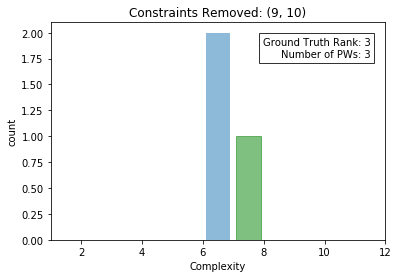

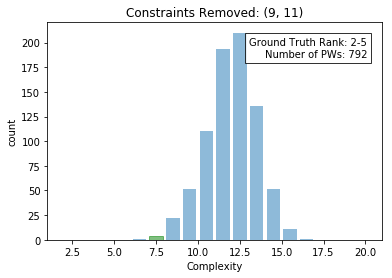

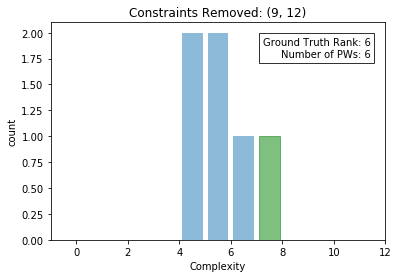

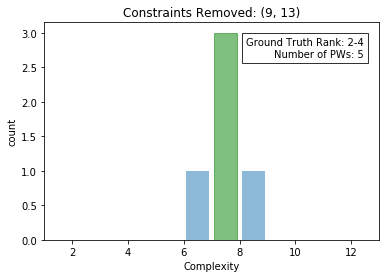

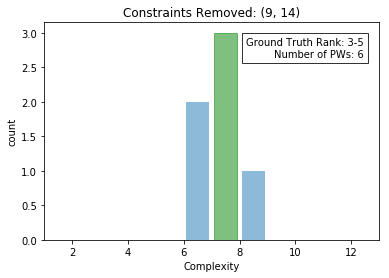

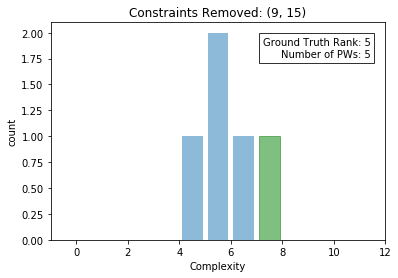

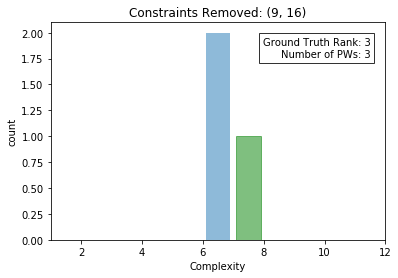

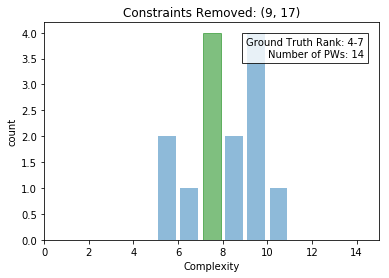

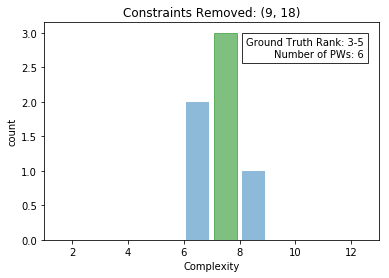

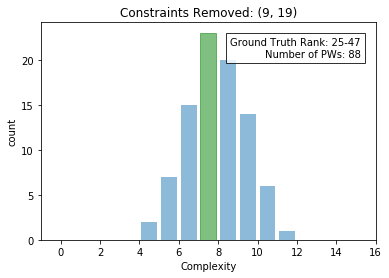

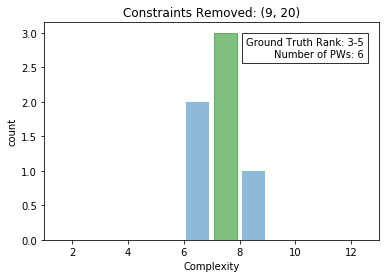

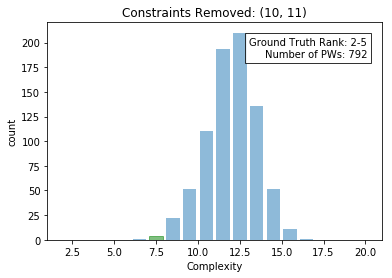

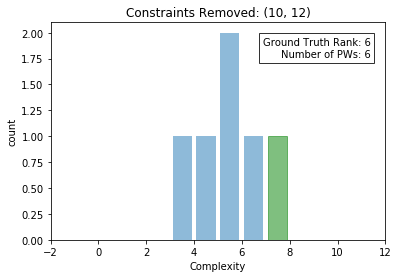

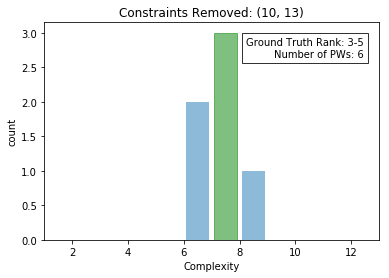

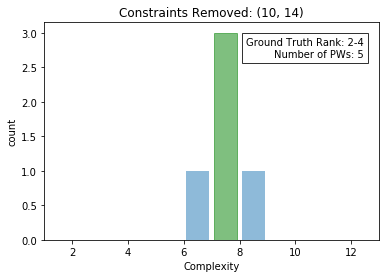

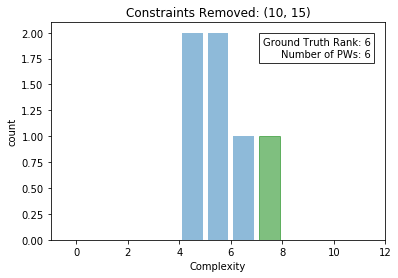

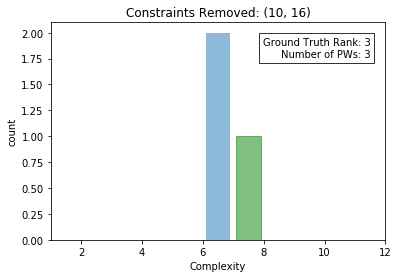

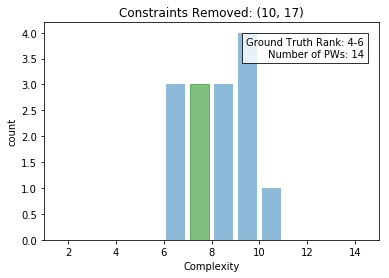

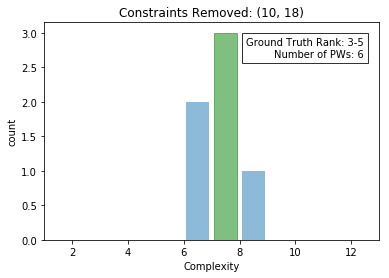

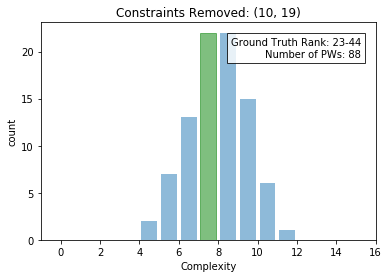

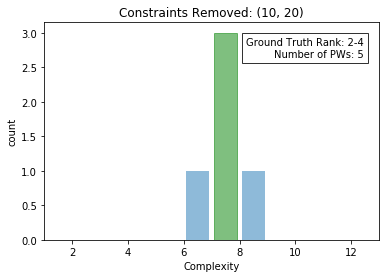

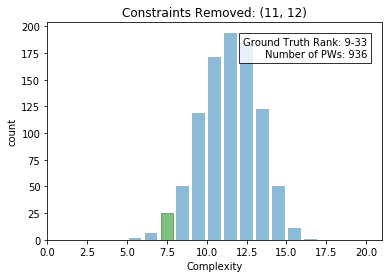

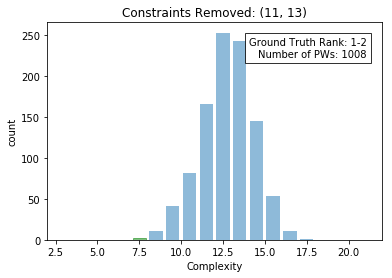

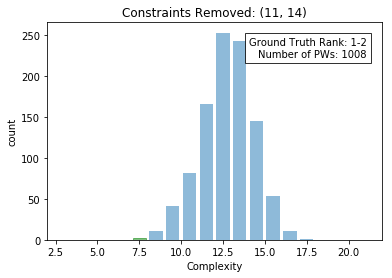

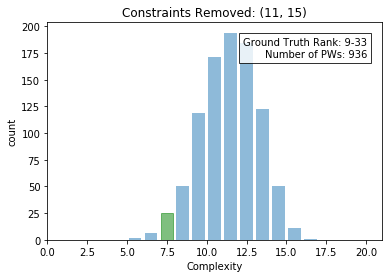

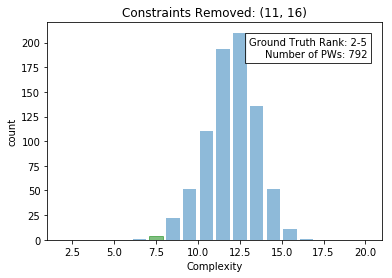

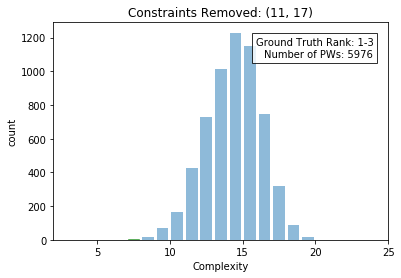

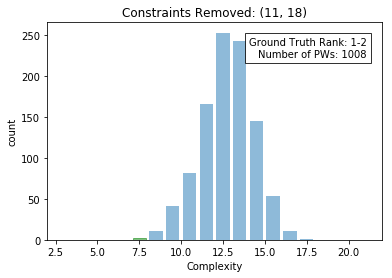

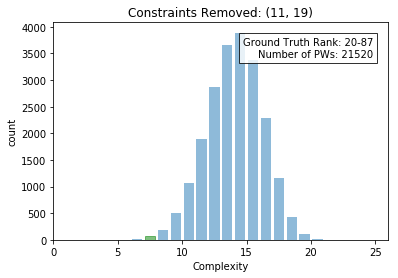

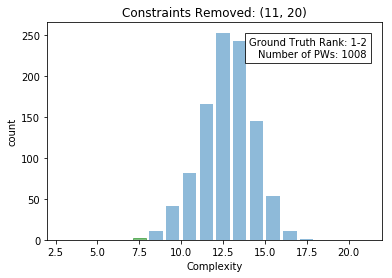

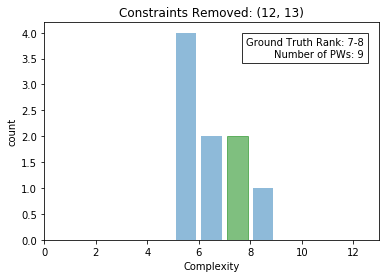

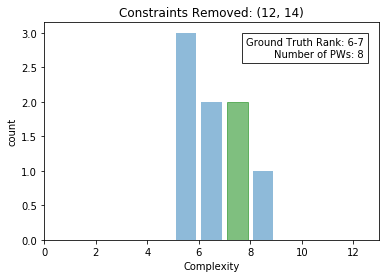

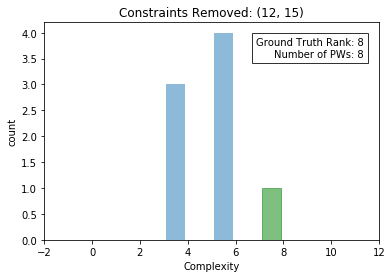

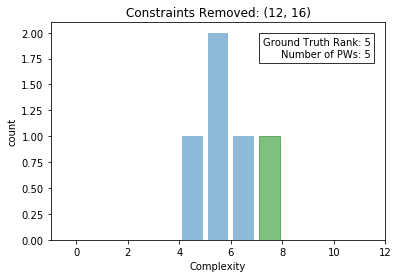

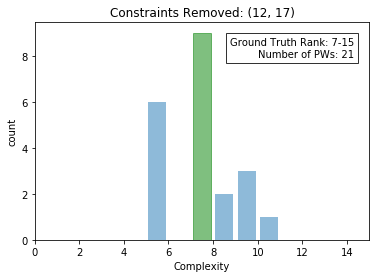

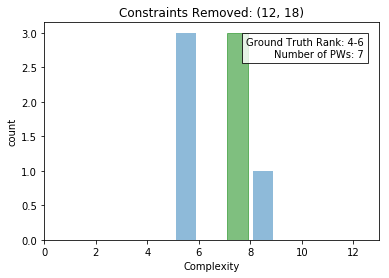

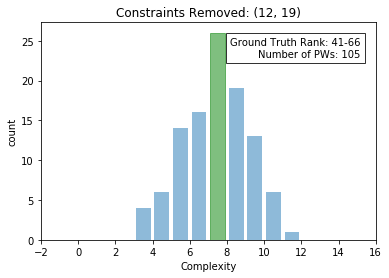

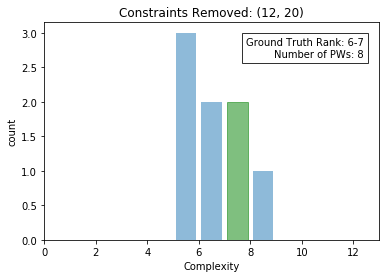

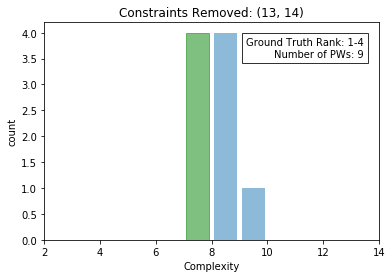

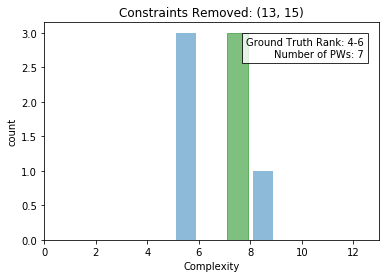

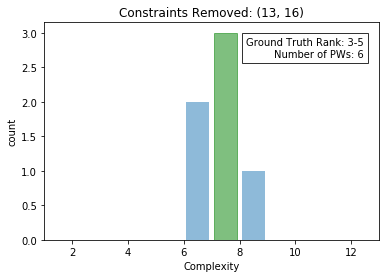

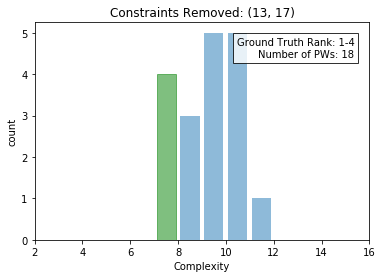

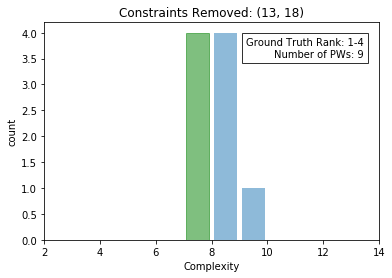

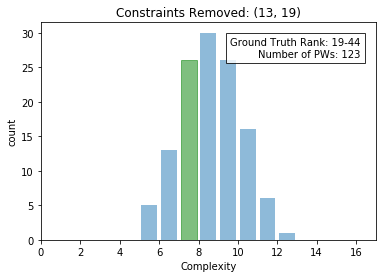

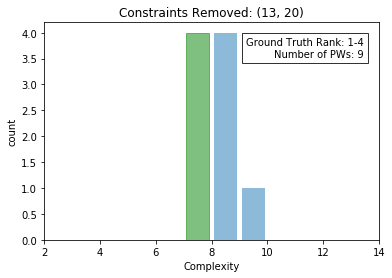

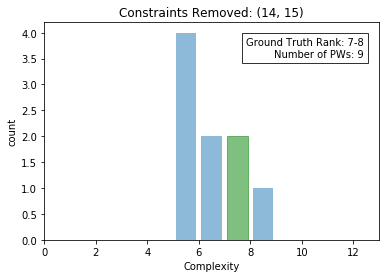

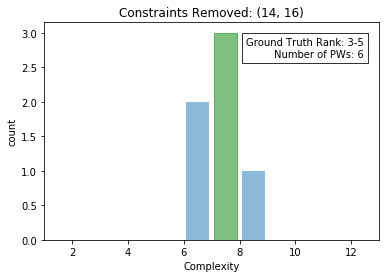

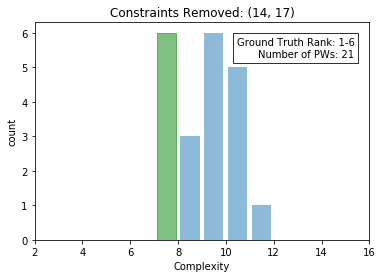

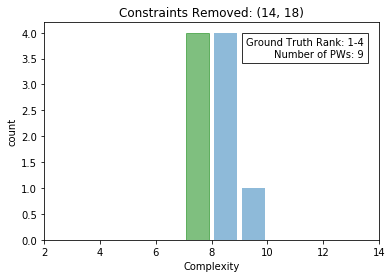

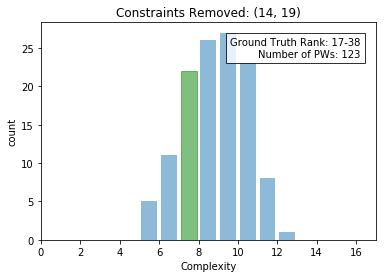

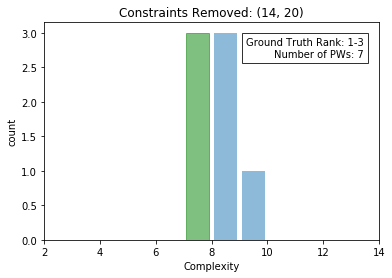

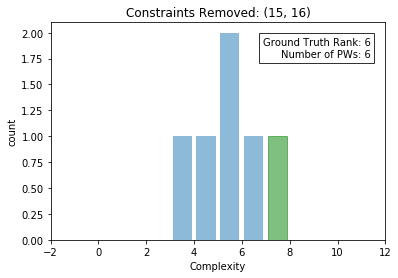

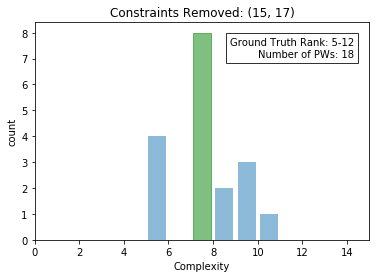

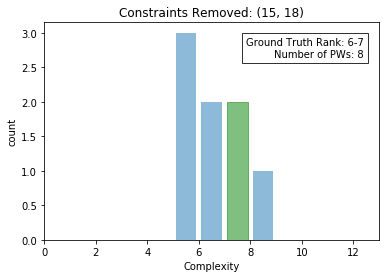

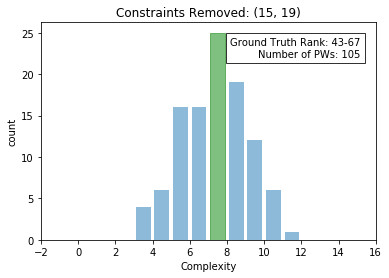

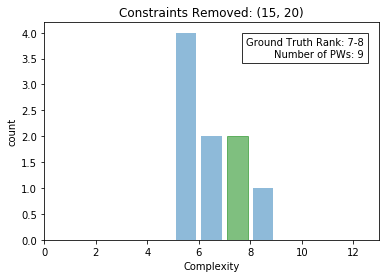

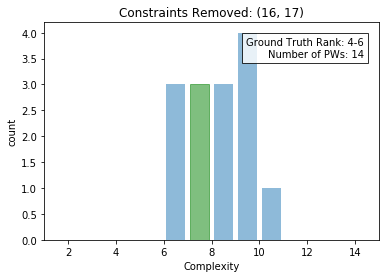

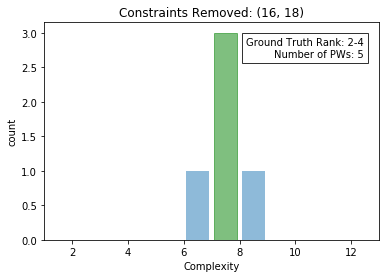

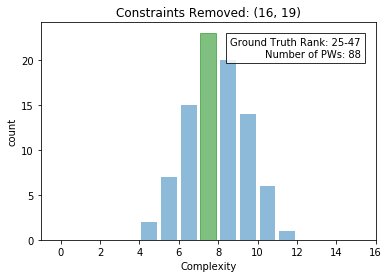

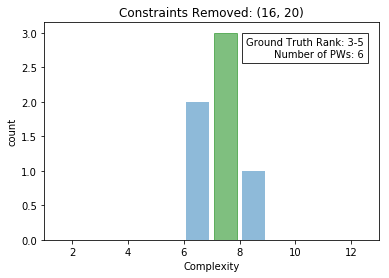

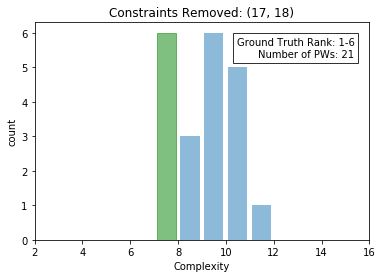

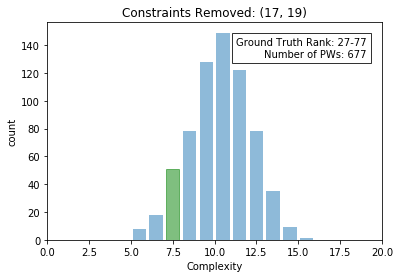

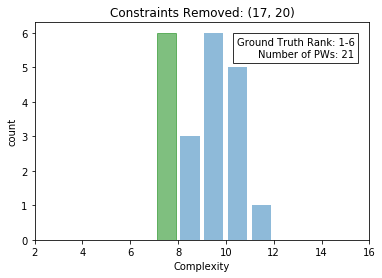

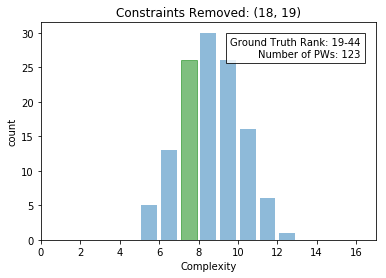

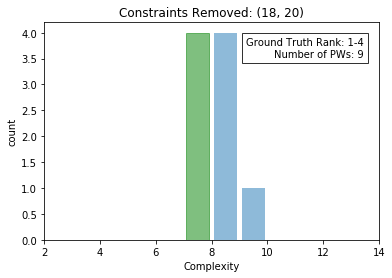

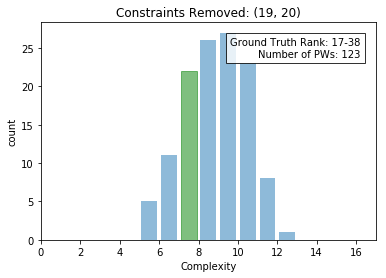

Performance Score: 0.9812914826665257


In [213]:
plot_performance(results)

In [247]:
result_in_focus = results['post_relaxation'][(15,19)]

In [248]:
result_in_focus.keys()

dict_keys(['complexities', 'dfs', 'pws', 'rels', 'gt_complexity_rank', 'shares_rank_with'])

In [253]:
result_in_focus['complexities']

[(4, 3),
 (14, 3),
 (34, 3),
 (38, 3),
 (1, 4),
 (2, 4),
 (12, 4),
 (18, 4),
 (46, 4),
 (66, 4),
 (5, 5),
 (6, 5),
 (8, 5),
 (15, 5),
 (16, 5),
 (22, 5),
 (35, 5),
 (36, 5),
 (39, 5),
 (40, 5),
 (42, 5),
 (47, 5),
 (62, 5),
 (68, 5),
 (70, 5),
 (82, 5),
 (3, 6),
 (9, 6),
 (13, 6),
 (19, 6),
 (20, 6),
 (23, 6),
 (26, 6),
 (48, 6),
 (50, 6),
 (54, 6),
 (63, 6),
 (67, 6),
 (72, 6),
 (74, 6),
 (83, 6),
 (90, 6),
 (7, 7),
 (10, 7),
 (17, 7),
 (24, 7),
 (27, 7),
 (28, 7),
 (30, 7),
 (37, 7),
 (41, 7),
 (43, 7),
 (44, 7),
 (49, 7),
 (51, 7),
 (55, 7),
 (56, 7),
 (64, 7),
 (69, 7),
 (71, 7),
 (76, 7),
 (78, 7),
 (84, 7),
 (86, 7),
 (91, 7),
 (92, 7),
 (94, 7),
 (11, 8),
 (21, 8),
 (25, 8),
 (29, 8),
 (31, 8),
 (32, 8),
 (52, 8),
 (57, 8),
 (58, 8),
 (65, 8),
 (73, 8),
 (75, 8),
 (80, 8),
 (85, 8),
 (87, 8),
 (93, 8),
 (95, 8),
 (96, 8),
 (98, 8),
 (33, 9),
 (45, 9),
 (53, 9),
 (59, 9),
 (60, 9),
 (77, 9),
 (79, 9),
 (88, 9),
 (97, 9),
 (99, 9),
 (100, 9),
 (102, 9),
 (61, 10),
 (81, 10),
 (89,

In [249]:
less_complex_than_gt = list(zip(*list(filter(lambda x: x[1] < results['gt_complexity'], result_in_focus['complexities']))))[0]

In [250]:
less_complex_than_gt

(4,
 14,
 34,
 38,
 1,
 2,
 12,
 18,
 46,
 66,
 5,
 6,
 8,
 15,
 16,
 22,
 35,
 36,
 39,
 40,
 42,
 47,
 62,
 68,
 70,
 82,
 3,
 9,
 13,
 19,
 20,
 23,
 26,
 48,
 50,
 54,
 63,
 67,
 72,
 74,
 83,
 90)

In [251]:
pws_vizs = euler_visualization_nxpd.visualize(dfs=result_in_focus['dfs'], pws=result_in_focus['pws'], relations=result_in_focus['rels'], conn=None, project_name='ndc_tz_11&19_rmvd', save_to_folder=None)

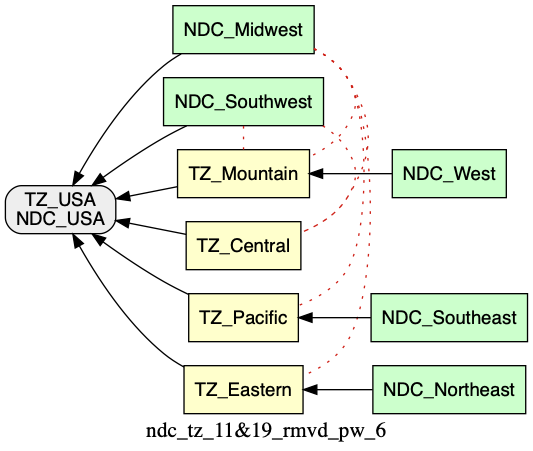

In [340]:
draw(pws_vizs[5])

In [214]:
# In general it seems like the performance is really good when there are a lot of PWs, less so when there are only a few PWs

In [215]:
# plt.scatter(range(1, len(results['post_relaxation'][(21, 22, 24)]['complexities'])+1), list(zip(*results['post_relaxation'][(21, 22, 24)]['complexities']))[1])
# plt.scatter(x=0, y=-1, color='green')
# plt.axhline(y=-1)
# plt.ylabel('Complexity')

In [216]:
with open('ndc_tz_results_2_at_a_time.pkl', 'wb') as f:
    pkl.dump(results, f)

In [15]:
cen_ndc_results = None
cen_tz_results = None
ndc_tz_results = None
magnolia_83_14_results = None
magnolia_91_14_results = None
magnolia_12_14_results = None
autos_results = None
ndc_tz_2_at_a_time_results = None
with open('cen_ndc_results.pkl', 'rb') as f:
    cen_ndc_results = pkl.load(f)
with open('cen_tz_results.pkl', 'rb') as f:
    cen_tz_results = pkl.load(f)
with open('ndc_tz_results.pkl', 'rb') as f:
    ndc_tz_results = pkl.load(f)
with open('magnolia_83_14_results.pkl', 'rb') as f:
    magnolia_83_14_results = pkl.load(f)
with open('magnolia_91_14_results.pkl', 'rb') as f:
    magnolia_91_14_results = pkl.load(f)
with open('magnolia_2012_results.pkl', 'rb') as f:
    magnolia_12_14_results = pkl.load(f)
with open('autos_results.pkl', 'rb') as f:
    autos_results = pkl.load(f)
# with open('ndc_tz_results_2_at_a_time.pkl', 'rb') as f:
#     ndc_tz_2_at_a_time_results = pkl.load(f)

In [ ]:
draw(autos_results['gt_dfs'])

Constraints:
              Node1 Relation            Node2
0         "NDC_USA"   parent    "NDC_Midwest"
1         "NDC_USA"   parent  "NDC_Northeast"
2         "NDC_USA"   parent  "NDC_Southeast"
3         "NDC_USA"   parent  "NDC_Southwest"
4         "NDC_USA"   parent       "NDC_West"
5          "TZ_USA"   parent     "TZ_Pacific"
6          "TZ_USA"   parent    "TZ_Mountain"
7          "TZ_USA"   parent     "TZ_Central"
8          "TZ_USA"   parent     "TZ_Eastern"
9     "NDC_Midwest"        o     "TZ_Eastern"
10    "NDC_Midwest"        o    "TZ_Mountain"
11        "NDC_USA"        =         "TZ_USA"
12  "NDC_Southwest"        o    "TZ_Mountain"
13  "NDC_Southeast"        !    "TZ_Mountain"
14       "NDC_West"        !     "TZ_Central"
15  "NDC_Southeast"        o     "TZ_Central"
16    "NDC_Midwest"        o     "TZ_Central"
17  "NDC_Northeast"        <     "TZ_Eastern"
18  "NDC_Southwest"        !     "TZ_Eastern"
19       "NDC_West"        >     "TZ_Pacific"
20       "NDC_West"  

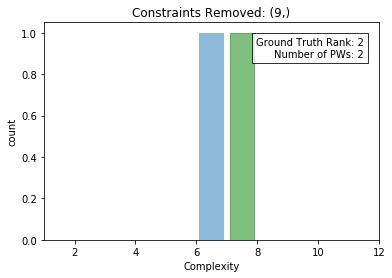

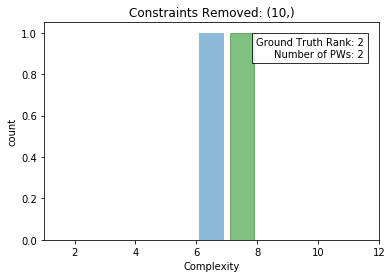

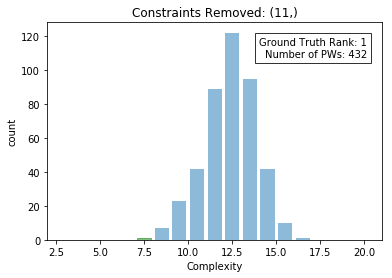

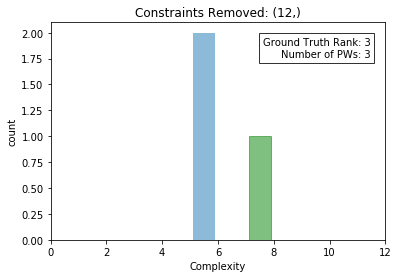

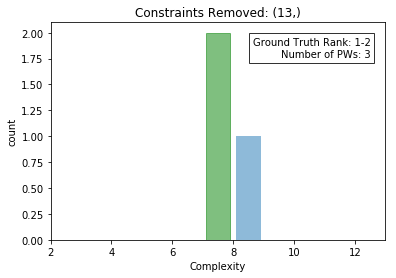

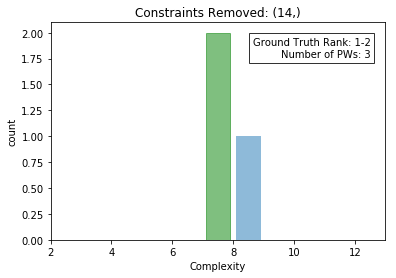

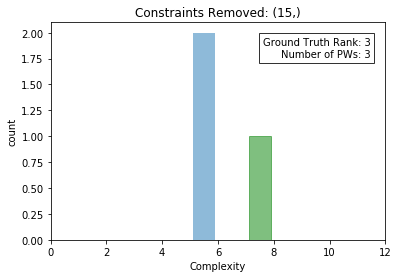

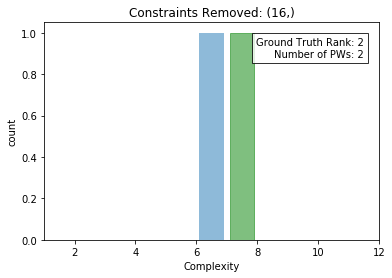

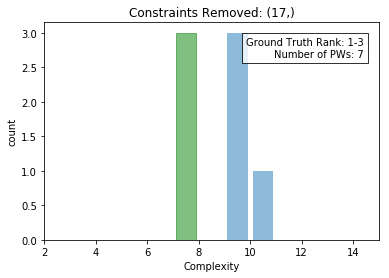

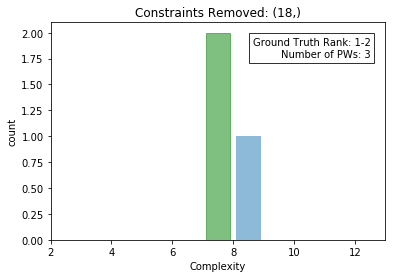

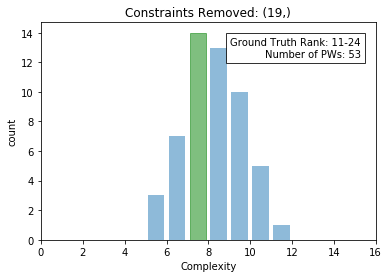

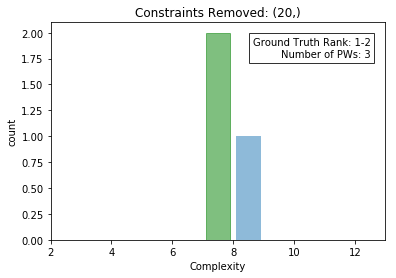

Performance Score: 0.9253875968992248


In [13]:
plot_performance(ndc_tz_results)

In [30]:
f_ex = ndc_tz_results['post_relaxation'][(19,)]

In [37]:
f_ex_dfs = f_ex['dfs']
f_ex_pws = f_ex['pws']
f_ex_rels = f_ex['rels']
f_ex_complexities = f_ex['complexities']
f_ex_gt_complexity_rank = f_ex['gt_complexity_rank']

In [43]:
f_ex_complexities

[(2, 5),
 (6, 5),
 (18, 5),
 (1, 6),
 (3, 6),
 (7, 6),
 (10, 6),
 (22, 6),
 (30, 6),
 (38, 6),
 (4, 7),
 (8, 7),
 (11, 7),
 (12, 7),
 (14, 7),
 (19, 7),
 (20, 7),
 (23, 7),
 (24, 7),
 (31, 7),
 (32, 7),
 (39, 7),
 (40, 7),
 (42, 7),
 (5, 8),
 (9, 8),
 (13, 8),
 (15, 8),
 (16, 8),
 (25, 8),
 (26, 8),
 (33, 8),
 (34, 8),
 (41, 8),
 (43, 8),
 (44, 8),
 (46, 8),
 (17, 9),
 (21, 9),
 (27, 9),
 (28, 9),
 (35, 9),
 (36, 9),
 (45, 9),
 (47, 9),
 (48, 9),
 (50, 9),
 (29, 10),
 (37, 10),
 (49, 10),
 (51, 10),
 (52, 10),
 (53, 11)]

In [42]:
f_ex_vizs = euler_visualization_nxpd.visualize(dfs=f_ex_dfs, pws=f_ex_pws, relations=f_ex_rels, conn=None, project_name='ndc_tz', save_to_file=False)

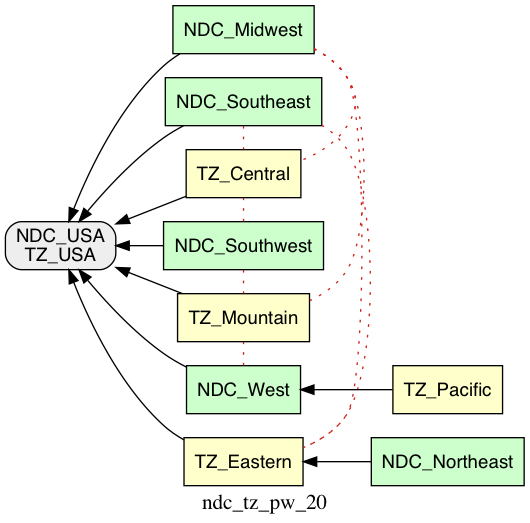

In [130]:
draw(f_ex_vizs[19])

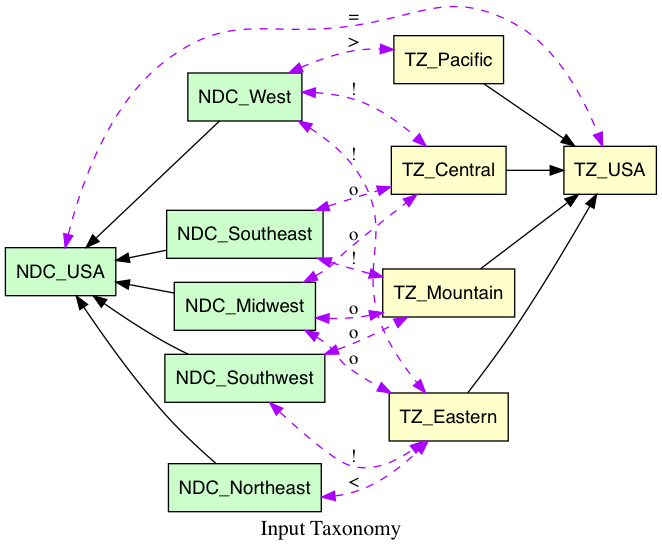

In [120]:
draw(visualize_euler_input(rel_data=ndc_tz_results['gt_rel_data'], taxes=ndc_tz_results['tax_data']))

In [256]:
# results = {
#     'gt_dfs': gt_dfs,
#     'gt_pws': gt_pws,
#     'gt_rel_data': gt_rel_data,
#     'tax_data': tax_data,
#     'post_relaxation': {},
# }

In [596]:
# gt_complexity = complexity(1, gt_dfs, gt_rels)
# gt_complexity

In [275]:
# for rel_to_rmv in range(21, len(gt_rel_data)):
#     k = list(range(len(gt_rel_data)))
#     k.remove(rel_to_rmv)
#     rel_data = gt_rel_data.iloc[k,:].copy(deep=False)
#     # G = visualize_euler_input(rel_data, tax_data)
#     # draw(G)
#     rules = LeanEuler.gen_asp_rules(rel_data, tax_data, encoding='mnpw')
#     clingo_soln = run_clingo(clingo_rules=rules)
#     # print('\n'.join(clingo_soln2))
#     dfs, rels, pws = load_worlds(clingo_output=clingo_soln, preprocessed=False, reasoner='clingo')
#     # print(list(map(lambda x: x.__dict__, rels2)))
    
#     #gt_pw_id = find_gt_pw_id(pws, gt_pws, rels, gt_rels)
#     #if gt_pw_id is None:
#     #    print("Couldn't find the ground truth PW.")
#     #    continue
    
#     # pws_vizs = euler_visualization_nxpd.visualize(dfs=dfs, pws=pws, relations=rels, conn=None, project_name='cen_ndc', save_to_file=False)
#     # draw(pws_vizs[19])
#     complexities = []
#     for i in range(len(pws)):
#         complexities.append((i+1, complexity(i+1, dfs, rels)))
#     # complexities = np.array(complexities)
#     complexities = sorted(complexities, key=lambda x: x[1])
#     dist_matrix = [(i+1, dist_func(rels, dfs, pws, gt_pw_id, i+1)) for i in range(len(pws)) if i+1 != gt_pw_id]
#     dist_matrix = sorted(dist_matrix, key= lambda x: x[1])
    
#     #gt_rank = find_rank(gt_pw_id, complexities)
    
#     gt_rank = find_rank_by_complexity(gt_complexity, complexities)
    
#     print("Rank of Ground Truth: {}".format(gt_rank))
    
#     results['post_relaxation'][rel_to_rmv] = {
#         'dist_matrix': dist_matrix,
#         'complexities': complexities,
#         'gt_pw_id': gt_pw_id,
#         'dfs': dfs,
#         'pws': pws,
#         'rels': rels,
#         'gt_complexity_rank': gt_rank,
#     }

In [271]:
# results.keys()

In [270]:
#results['post_relaxation'][21]['complexities']

In [272]:
# for c_id in results['post_relaxation']:
#     relaxed_constraint = results['gt_rel_data'].loc[c_id]
#     print("On relaxation of the {} {} {} constraint:".format(relaxed_constraint['Node1'], relaxed_constraint['Relation'], relaxed_constraint['Node2']))
#     print("Ground Truth ranks {} out of the {} possible worlds".format(results['post_relaxation'][c_id]['gt_complexity_rank'], len(results['post_relaxation'][c_id]['pws'])))

In [273]:
#cen_ndc_results.keys()

In [274]:
# for results in [cen_ndc_results, cen_tz_results, ndc_tz_results]:
#     for c_id in results['post_relaxation']:
#         relaxed_constraint = results['gt_rel_data'].loc[c_id]
#         print("On relaxation of the {} {} {} constraint:".format(relaxed_constraint['Node1'], relaxed_constraint['Relation'], relaxed_constraint['Node2']))
#         print("Ground Truth ranks {} out of the {} possible worlds".format(results['post_relaxation'][c_id]['gt_complexity_rank'], len(results['post_relaxation'][c_id]['pws'])))